# Figure B: Cross section

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.colors import ListedColormap
import xarray as xr 

#plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size': 12})

import warnings
warnings.filterwarnings("ignore")

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
def compute_air_density(temperature, pressure):
    R_d = 287.05  # J/(kg·K), specific gas constant for dry air
    air_density = pressure / (R_d * temperature)
    return air_density

In [4]:
def assign_h_as_coors(data, h):
    data = data.assign_coords(height=h)
    return data

## Prepare Data

In [5]:
frp =  xr.open_mfdataset("/work/bb1174/user/jason/hamlite/icon_input/data_any_2019/frp/frp_any_2019.nc", engine = 'netcdf4').isel(time = 363)

In [103]:
data_path = "/scratch/b/b381531/experiments/lam_any_2019/run_1000/"
ca = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z_regrid.nc", engine = 'netcdf4').num_qca
dust = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z_regrid.nc", engine = 'netcdf4').num_qdu
h = xr.open_mfdataset(data_path + "lam_any_2019_atm_vgrid_ml.nc", engine = 'netcdf4').zg.mean("ncells")/1000

h = h.rename({"height_2": "height"})

In [46]:
# Get height of Troposphere
tropoheight = xr.open_mfdataset(data_path + "*std*Z.nc", engine = 'netcdf4').ptp.mean(("ncells", "time"))
p = xr.open_mfdataset(data_path + "*trc_3d_ml_2019*Z.nc", engine = 'netcdf4').pfull.mean(("ncells", "time"))

closest_index = np.abs(p - tropoheight).argmin().values.item()
tropoheight = h[closest_index].values/1000

In [47]:
ca = ca.assign_coords(height=h)
dust = dust.assign_coords(height=h)

In [48]:
lon = dust.lon
lat = dust.lat

## Plot Crosssection

In [142]:
# Get the colormaps right
nlevel = 50

base_cmap = plt.cm.get_cmap("gist_heat_r", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
colors[1] = [1, 1, 1, 0.25]
colors[2] = [1, 1, 1, 0.75]
custom_cmap_du = ListedColormap(colors)

base_cmap = plt.cm.get_cmap("Greys", nlevel)  
colors = base_cmap(np.linspace(0, 1, nlevel))
colors[0] = [1, 1, 1, 0]
colors[1] = [1, 1, 1, 0.25]
colors[2] = [1, 1, 1, 0.75]
custom_cmap_ca = ListedColormap(colors)

In [143]:
# Some Settings for the plot
time = 90

maxval_ca = 9
maxval_du = 9
levs_ca = np.arange(0, maxval_ca, maxval_ca / nlevel)
levs_du = np.arange(0, maxval_du, maxval_du / nlevel)

center_lat = -35.5 #Adjust the center latitude
dlat = 0.5  #Adjust the space around the center latitude where the data should be averaged in 

## Transect in a latitude band
dust_sec = dust.isel(time = time).sel(lat = slice(center_lat - dlat, center_lat + dlat)).mean("lat")*1e-4
ca_sec = ca.isel(time = time).sel(lat = slice(center_lat - dlat, center_lat + dlat)).mean("lat")*1e-9

# Alternative: Transect in a single latitude line
#dust_sec = dust.isel(time = time).sel(lat = center_lat, method = "nearest")*1e-4
#ca_sec = ca.isel(time = time).sel(lat = center_lat, method = "nearest")*1e-9


Text(1.0, 1.0, 'Crosssection along -35.5°')

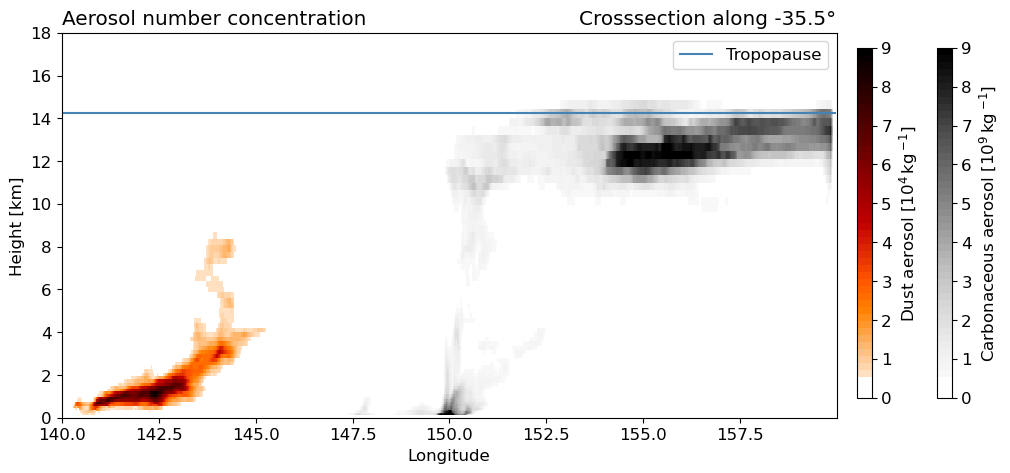

In [145]:
fig, ax = plt.subplots(figsize = (10,5))

## Plot with free levels
#c1 = ax.pcolormesh(lon, h, dust_sec, cmap = custom_cmap_du)
#c2 = ax.pcolormesh(lon, h, ca_sec, cmap = custom_cmap_ca)

# Alternative: Plot with fixed levels
c1 = ax.pcolormesh(lon, h, dust_sec, cmap = custom_cmap_du, vmin = 0, vmax = maxval_du)
c2 = ax.pcolormesh(lon, h, ca_sec, cmap = custom_cmap_ca, vmin = 0, vmax = maxval_ca)

## Alternative: contour plot
#c1 = ax.contourf(lon, h, dust_sec, cmap = custom_cmap_du, levels = levs_du, extend = "max")
#c2 = ax.contourf(lon, h, ca_sec, cmap = custom_cmap_ca,levels = levs_ca, extend = "max")


plt.hlines(y = tropoheight, xmin = np.min(lon), xmax = np.max(lon), label = "Tropopause", colors = "steelblue")
plt.legend()
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(c1, cax=cbar_ax, orientation="vertical", label=f"Dust aerosol [10$^{4}\,$kg$\,^{{-1}}$]")

cbar_ax2 = fig.add_axes([1, 0.15, 0.015, 0.7])
fig.colorbar(c2, cax=cbar_ax2, orientation="vertical", label=f"Carbonaceous aerosol [10$^{9}\,$kg$\,^{{-1}}$]")

ax.set_ylim(0, 18)
ax.set_xlabel("Longitude")
ax.set_ylabel("Height [km]")
ax.set_title("Aerosol number concentration", loc = "left")
ax.set_title("Crosssection along "+ str(center_lat)+"°", loc = "right")